In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [3]:
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi
r_m = 0.1
N0_squared = 100
epsilon = 0.01

k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
              [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
              [L_plus, np.zeros((2, 2))]])

In [4]:
#xi = np.array([(2 * np.random.normal(0, 1, 4) * np.sqrt(2)) / k_e, 0, 0, 0])

#def dsdt(t, s, U, noise=None):
#    return W @ s + U * (L @ s) + np.sqrt(epsilon) * np.array([2.8 / k_e, 0, 0, 0]) * noise

def dsdt(t, s, U, noise=None):
    determ = W @ s + U * (L @ s)
    
    if noise is not None:
        stoch = np.sqrt(epsilon) * np.array([2.8 / k_e, 0, 0, 0]) * noise
        return determ + stoch
    else:
        return determ
    
def dUdt(t, s, U):
    psi_e, _, psi_p, _ = s
    return 0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p - r_m * U

In [5]:
def rhs(t, y):
    s, U = y[:4], y[4]
    ds = dsdt(t, s, U)
    dU = dUdt(t, s, U)
    return np.concatenate((ds, [dU]))

In [6]:
initial_state = np.array([0, 0, 0, 0, 0.001])
t_span = (0, 10)
dt = 0.00001

In [7]:
##Using Euler-Maruyama Method for Stochastic Differential Equations(SDE)-

def rhs_stoch(t, y):
    s, U = y[:4], y[4]
    noise = np.random.normal(0, 1, 4)
    ds = dsdt(t, s, U, noise=noise)
    return np.concatenate((ds, np.zeros(1)))

def sde_euler(rhs, rhs_stoch, y0, t_span, dt):
    t0, tf = t_span
    t = np.arange(t0, tf + dt, dt)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        y_determ = dt * rhs(t[i-1], y[:, i-1])
        y_stoch =  np.sqrt(dt) * rhs_stoch(t[i-1], y[:, i-1])

        y[:, i] = y[:, i-1] + y_determ + y_stoch

    return t, y

In [69]:
def sde_euler(rhs, y0, t_span, dt, noise_std):
    t0, tf = t_span
    t = np.arange(t0, tf + dt, dt)
    n = len(t)
    y = np.zeros((len(y0), n))
    y[:, 0] = y0
    
    for i in range(1, n):
        noise = np.random.normal(0, noise_std, len(y0))
        noise[:4] *= np.array([2.8 / k_e, 0, 0, 0]) * np.sqrt(epsilon)  
        noise[4] = 0  
        
        y_determ = dt * rhs(t[i-1], y[:, i-1])
        y_stoch = np.sqrt(dt) * noise

        y[:, i] = y[:, i-1] + y_determ + y_stoch

    return t, y

In [8]:
t_sde, y_sde = sde_euler(rhs, rhs_stoch, initial_state, t_span, dt)

In [71]:
t_sde, y_sde = sde_euler(rhs, initial_state, t_span, dt, noise_std=1.0)

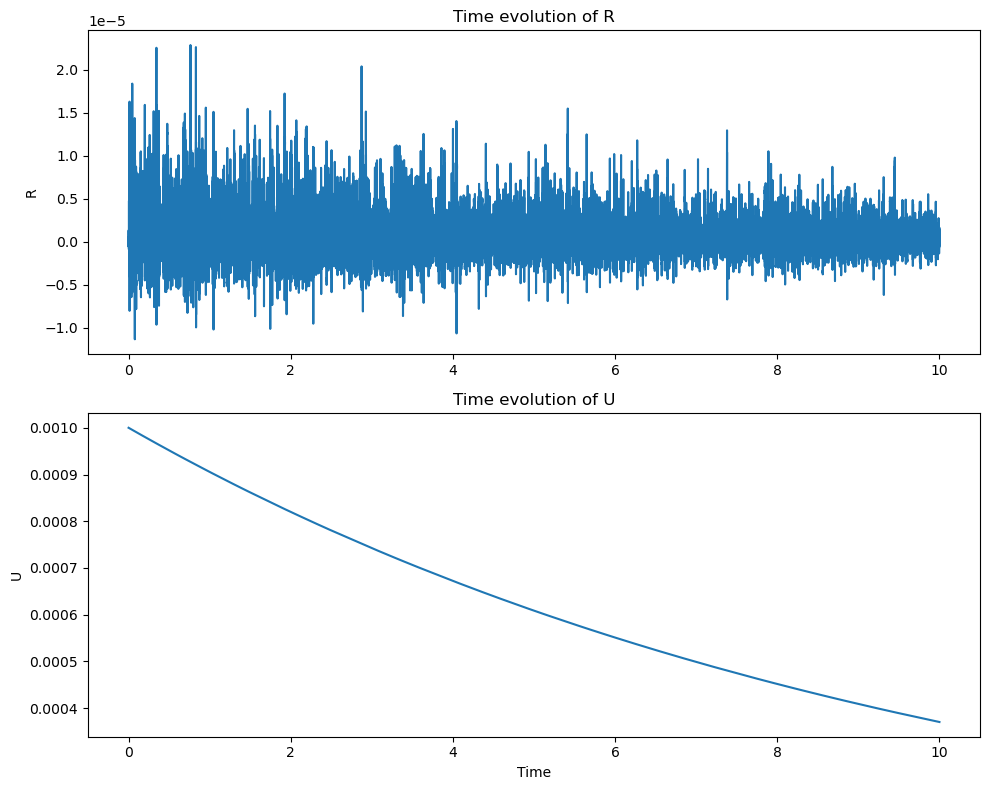

In [9]:
R_value_sde = 0.25 * k * (k_plus**2 - k_e**2) * y_sde[0] * y_sde[2]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(t_sde, R_value_sde,'-')
axs[0].set_title("Time evolution of R")
axs[0].set_ylabel("R")

axs[1].plot(t_sde, y_sde[4],'-')
axs[1].set_title("Time evolution of U")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("U")

plt.tight_layout()
plt.show()

noise_values = (2 * np.random.normal(0, 1, 4) * np.sqrt(2)) / k_e
xi = np.array([noise_values[0], 0, 0, 0])

In [13]:
nu = np.random.normal(0,1,4)

print(nu)

[ 0.42347973  0.3787333   1.23983035 -0.68271931]
